<a href="https://colab.research.google.com/github/davidepelliciari/MCMC/blob/master/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analisi bayesiana di un sample di dati attraverso l'uso di MCMC

# 1. Creazione dei dati e analisi bayesiana




Buongiorno. Il codice che andiamo a descrivere permette di ricavare degli intervalli di fiducia per 3 parametri di un fit lineare. Il codice python genera dei dati random e cerca di stimare la pendenza della retta del fit (m), l'intercetta con l'asse y (b) e un parametro legato alla varianza (f). Il codice che andremo ad analizzare è stato preso da emcee, e lo potete trovare descritto in lingua inglese al sito https://emcee.readthedocs.io/en/stable/tutorials/line/

Per prima cosa importiamo le librerie che ci serviranno e definiamo i valori "veri" dei parametri del fit, li confronteremo con i valori trovati dall'analisi bayesiana:

In [0]:
import matplotlib.pyplot as plt
import scipy.optimize as op
!pip install emcee
import emcee
!pip install corner
import corner
import numpy as np

m_true = -0.9594
b_true = 4.294
f_true = 0.534

Iniziamo con la generazione dei dati. Partiamo generando un numero N di valori x distribuiti randomicamente. A questo punto

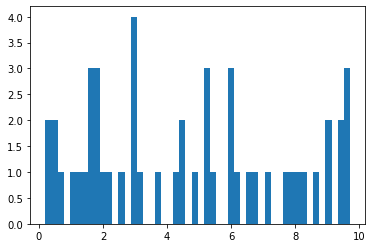

In [36]:
N = 50
x = np.sort(10*np.random.rand(N))
plt.hist(x,N)
plt.show()

A questo punto passiamo alla creazione dei valori y. Vogliamo partire dalla retta ideale y = mx + b, "m" e "b" i parametri veri definiti sopra. A questi valori aggiungiamo 

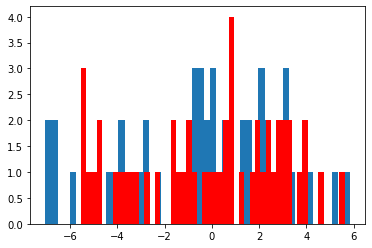

In [37]:
y = m_true*x + b_true
y1 = y + np.random.randn(N) #Confronto con una tipica distribuzione gaussiana
y += np.abs(f_true*y)*np.random.randn(N) #Vera distribuzione dei dati

plt.hist(y,50)
plt.hist(y1,50,color="red")
plt.show()

A questo punto i nostri dati, rappresentati su un grafico (x,y), dovrebbero essere più o meno questi:

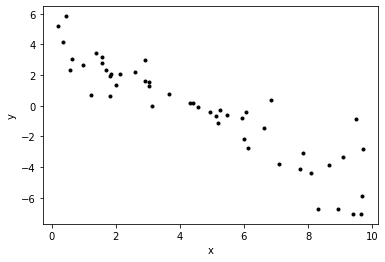

In [38]:
plt.plot(x,y,marker='.',color='k',linestyle='')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Aggiungiamo allora le barre di errore per le nostre N misurazioni. Simuleremo queste barre di errore in modo tale che il valore di ogni errore sarà distribuito gaussianamente per le misurazioni:

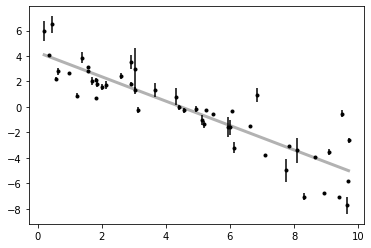

In [39]:
yerr = 0.1+0.5*np.random.randn(N)
yerr = yerr*np.random.randn(N)

y+=yerr

plt.errorbar(x,y,yerr,linestyle='',color='k',marker='.')
plt.plot(x, m_true * x + b_true, "k", alpha=0.3, lw=3)  #Fit con i dati "veri"
plt.show()

A questo punto possiamo partire con l'analisi bayesiana dei dati. Per ottenere la probabilità a posteriori $p(\theta|x)$ che il fit sia descritto dai valori $\theta = (m,b,f)$ dato il sample $(x,y)$, è necessario definire la funzione likelihood $p(x|\theta)$ di ottenere i dati del sample assumendo i valori $\theta$ e la prior probability. Definiamo la likelihood come gaussiana e scegliamo una flat prior, in particolare scegliamo di definire il logaritmo di queste probabilità, e questo sarà più chiaro tra un attimo quando definiremo la catena di Markov. In ogni modo la probabilità a posteriori è data da $p(\theta|x) \propto p(\theta)p(x|\theta)$.
In codice:



In [0]:
#LIKELIHOOD FUNCTION
def lnlike(theta,x,y,yerr):
    m,b,lnf = theta
    model = m*x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2-np.log(inv_sigma2)))

#DEF LOG PRIOR
def lnprior(theta):
    m,b,lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10 < lnf < 1.0:
        return 0.0
    return -np.inf

#DEF PROB
def lnprob(theta,x,y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y,yerr)

Passiamo allora alla determinazione dei maximum likelihood estimator, cioè quei parametri di $m$, $b$ e $ln(f)$ che massimizzano la likelihood. Sia $f=f(x)$ una funzione qualsiasi, si ha che:

$\frac{\partial f}{\partial x} = -\frac{\partial - f}{\partial x}$

Dunque possiamo ridurre la massimizzazione della likelihood a una *minimizzazione* della likelihood negativa $-p(x|\theta)$. Ed è proprio quello che fa la funzione 

```
optimize.minimize
```
Del pacchetto scipy. In codice:

In [0]:
np.random.seed(42)
nll = lambda *args: -lnlike(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = op.minimize(nll,initial, args=(x,y,yerr))
m_ml, b_ml, lnf_ml = soln.x

Ciò che fa questo pezzo di codice è definire una funzione anonima (lambda) nll pari, appunto, alla likelihood negativa. Si imposta una posizione iniziale dei parametri, che sarà in questo caso vicina ai parametri "veri" (si noti che abbiamo aggiunto una componente gaussiana) in modo tale che la funzione minimize converga più velocemente. A questo punto si crea il vettore soln, dato dalla soluzione dell'operazione svolta da minimize. In pratica l'operazione di minimizzare la likelihood (negativa) viene svolta nel modo seguente:

*   Viene passata la funzione nll, con "first guess" i parametri defini in initial. Questo sarà il vettore $\theta$ che compare nella definizione della likelihood;
*   Vengono passati i valori di $x,y$ e $yerr$ come ultimi.



Stampiamo a schermo i valori dei maximum likelihood estimators:

In [42]:
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(lnf_ml)))

Maximum likelihood estimates:
m = -0.938
b = 4.131
f = 0.537


#2. Catena di Markov-Monte Carlo (MCMC)

Per ottenere i valori dei parametri che massimizzano la posterior probability è necessario fare uso della catena di Markov-Monte Carlo. In pratica si parte da un sample di valori per i parametri, questi vengono poi fatti variare coprendo lo spazio dei parametri e ad ogni variazione si calcola la posterior. A seconda dei parametri che usciranno più spesso, e che quindi sono più probabili, si ottengono delle stime per essi. 

Ad ogni step temporale (per la nostra catena saranno 5000 steps), 32 catene in parallelo verranno fatte partire e ogni catena fa variare i parametri nei loro spazi descritti dalla prior. Partiamo allora dalla soluzione trovata, ovvero i MLE, e generiamo una matrice (32x3) in cui le colonne fanno riferimento ai 3 diversi parametri che vogliamo determinare e le righe fanno invece riferimento alle varie catene che partiranno in parallelo:

In [0]:
pos = soln.x + 1e-4*np.random.randn(32,3)
nwalkers, ndim = pos.shape

#print(pos)   #Vuoi vedere la matrice?

Ora che abbiamo settato la posizione iniziale da cui partiranno le nostre catene, inizializziamo il processo attraverso il comando EnsembleSampler di emcee:

In [0]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

Questo comando prepara le catene e associa la posterior probability per ognuno di questi parametri.

Siamo ora pronti per far partire la MCMC. E' semplicissimo, basta richiamare la funzione run_mcmc di emcee:

In [0]:
sampler.run_mcmc(pos,5000, progress=True)

Possiamo estrarre i dati del processo di MCMC attraverso il comando get_chain:

In [0]:
samples = sampler.get_chain()
print(samples.shape)

Da come si può verificare dal comando print, samples è un array in cui sono salvati tutti i valori dei parametri per ogni step della catena e per ogni walkers. Si può ottenere un grafico in cui viene mostrato il vero e proprio processo delle catene MCMC, cioè si mostra come vengono fatti spaziare i parametri nel loro "spazio a disposizione":

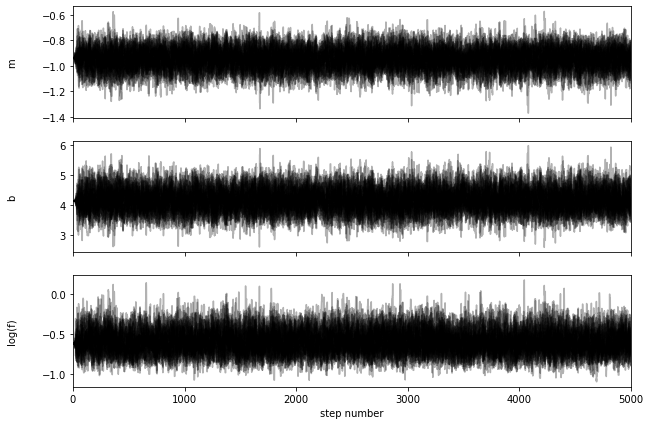

In [54]:
fig, axes = plt.subplots(3, figsize=(10,7), sharex=True)
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)

axes[-1].set_xlabel("step number")
plt.show()

Facciamo un piccolo taglio ai dati sopra prendendo i valori ogni 15 step e tagliando i primi 100 cicli, cioè diamo il tempo alla catena di "perdere memoria" dello stato iniziale:

In [55]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


Vogliamo quindi ottenere la distribuzione dei parametri ottenuti, e questo è possibile farlo semplicemente attraverso le seguenti righe di codice che produrranno i cosiddetti corner-plots:

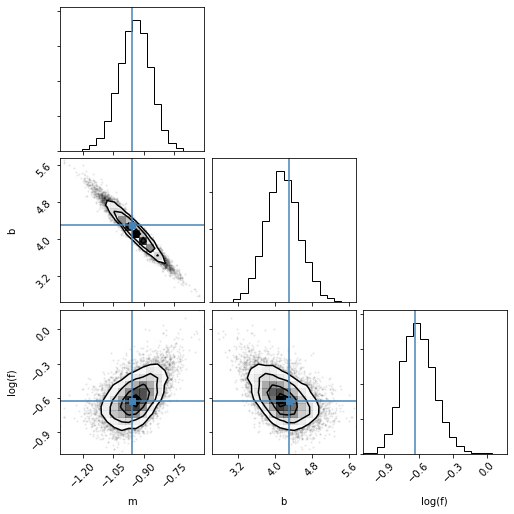

In [56]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)

plt.show()

Abbiamo ottenuto i seguenti valori per i parametri $m$, $b$ e $ln(f)$:

In [0]:
from IPython.display import display, Math
'exec(%matplotlib inline)'

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = '\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}'
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

$$\mathrm{m} = -0.944_{-0.081}^{0.076}$$
$$\mathrm{b} = 4.154_{-0.354}^{0.373}$$
$$\mathrm{log(f)} = -0.608_{-0.132}^{0.148}$$